<a href="https://colab.research.google.com/github/nfkttidrive3/algotrading/blob/main/newdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
pip install delta-rest-client

/usr/local/lib/python3.12/dist-packages/matplotlib/animation.py:908: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



In [80]:
from delta_rest_client import DeltaRestClient
delta_client = DeltaRestClient(
    base_url='https://api.india.delta.exchange',
    api_key='',
    api_secret=''
)

In [81]:
delta_client.base_url

'https://api.india.delta.exchange'

In [82]:
pip install websocket-client

Fetching ETHUSD market data...

=== ETHUSD Current Market Data ===
Current Price: $3023.6
24h High: $3070.35
24h Low: $2985.4
24h Volume: 214044.86999997427
Mark Price: $3023.57102709
Open Interest: 12991.2200
Fetching historical 1-minute candle data...
Received 119 candles
Creating chart...


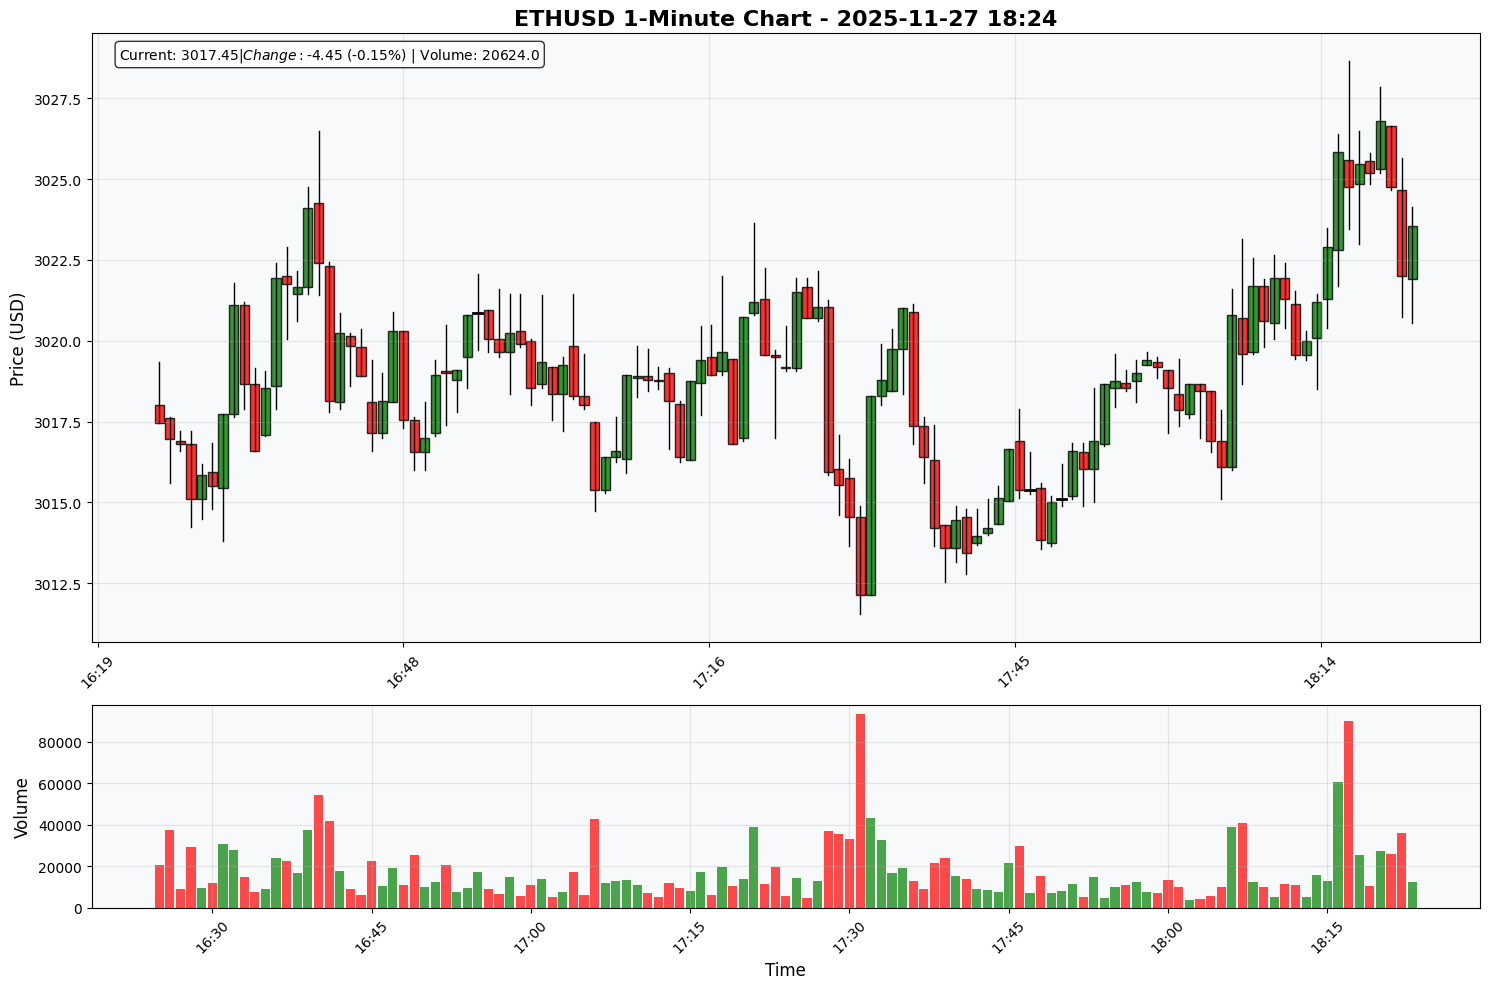

In [83]:
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import time

class ETHUSDChart:
    def __init__(self):
        self.base_url = 'https://api.india.delta.exchange'
        self.symbol = 'ETHUSD'

    def fetch_historical_data(self, hours_back=2):
        """Fetch historical 1-minute candle data"""
        end_time = int(time.time())
        start_time = end_time - (hours_back * 3600)  # hours back

        url = f"{self.base_url}/v2/history/candles"
        params = {
            'symbol': self.symbol,
            'resolution': '1m',
            'start': start_time,
            'end': end_time
        }

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            if data['success'] and data['result']:
                return data['result']
            else:
                print("No data received")
                return []

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            return []

    def create_candlestick_chart(self, data):
        """Create TradingView-style candlestick chart"""
        if not data:
            print("No data to plot")
            return

        # Convert to DataFrame
        df = pd.DataFrame(data)
        df['datetime'] = pd.to_datetime(df['time'], unit='s')

        # Create figure and subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10),
                                       gridspec_kw={'height_ratios': [3, 1]})

        # Plot candlesticks
        self.plot_candlesticks(ax1, df)

        # Plot volume
        self.plot_volume(ax2, df)

        # Format charts
        self.format_chart(ax1, ax2, df)

        plt.tight_layout()
        plt.show()

    def plot_candlesticks(self, ax, df):
        """Plot OHLC candlesticks"""
        for idx, row in df.iterrows():
            x = mdates.date2num(row['datetime'])
            open_price = row['open']
            high_price = row['high']
            low_price = row['low']
            close_price = row['close']

            # Determine color (green for bullish, red for bearish)
            color = 'green' if close_price >= open_price else 'red'

            # Draw high-low line
            ax.plot([x, x], [low_price, high_price], color='black', linewidth=1)

            # Draw candle body
            body_height = abs(close_price - open_price)
            body_bottom = min(open_price, close_price)

            if body_height > 0:
                rect = Rectangle((x - 0.0003, body_bottom), 0.0006, body_height,
                               facecolor=color, edgecolor='black', alpha=0.8)
                ax.add_patch(rect)
            else:
                # Doji candle (open == close)
                ax.plot([x - 0.0003, x + 0.0003], [open_price, open_price],
                       color='black', linewidth=2)

    def plot_volume(self, ax, df):
        """Plot volume bars"""
        colors = ['green' if close >= open else 'red'
                 for close, open in zip(df['close'], df['open'])]

        ax.bar(df['datetime'], df['volume'], color=colors, alpha=0.7, width=0.0006)

    def format_chart(self, ax1, ax2, df):
        """Format chart appearance"""
        # Main chart formatting
        ax1.set_title(f'ETHUSD 1-Minute Chart - {datetime.now().strftime("%Y-%m-%d %H:%M")}',
                     fontsize=16, fontweight='bold')
        ax1.set_ylabel('Price (USD)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.set_facecolor('#f8f9fa')

        # Volume chart formatting
        ax2.set_ylabel('Volume', fontsize=12)
        ax2.set_xlabel('Time', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_facecolor('#f8f9fa')

        # Format x-axis
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        # Rotate x-axis labels
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # Add current price info
        if not df.empty:
            current_price = df.iloc[-1]['close']
            current_volume = df.iloc[-1]['volume']
            price_change = current_price - df.iloc[0]['open']
            price_change_pct = (price_change / df.iloc[0]['open']) * 100

            info_text = f"Current: ${current_price:.2f} | Change: ${price_change:+.2f} ({price_change_pct:+.2f}%) | Volume: {current_volume:.1f}"
            ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    def get_current_ticker(self):
        """Get current ticker data"""
        url = f"{self.base_url}/v2/tickers/{self.symbol}"

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            data = response.json()

            if data['success']:
                ticker = data['result']
                print(f"\n=== ETHUSD Current Market Data ===")
                print(f"Current Price: ${ticker.get('close', 'N/A')}")
                print(f"24h High: ${ticker.get('high', 'N/A')}")
                print(f"24h Low: ${ticker.get('low', 'N/A')}")
                print(f"24h Volume: {ticker.get('volume', 'N/A')}")
                print(f"Mark Price: ${ticker.get('mark_price', 'N/A')}")
                print(f"Open Interest: {ticker.get('oi', 'N/A')}")
                print("=" * 35)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching ticker: {e}")

    def run(self):
        """Main function to create chart"""
        print("Fetching ETHUSD market data...")

        # Get current market info
        self.get_current_ticker()

        # Fetch historical data
        print("Fetching historical 1-minute candle data...")
        historical_data = self.fetch_historical_data(hours_back=2)

        if historical_data:
            print(f"Received {len(historical_data)} candles")
            print("Creating chart...")
            self.create_candlestick_chart(historical_data)
        else:
            print("Failed to fetch data. Please check your internet connection.")

# Real-time WebSocket version (optional)
def create_realtime_chart():
    """Create real-time updating chart using WebSocket"""
    import websocket
    import json
    import threading

    candle_data = []

    def on_message(ws, message):
        data = json.loads(message)
        if data.get('type') == 'candlestick_1m' and data.get('symbol') == 'ETHUSD':
            candle = {
                'time': data['candle_start_time'] // 1000000,  # Convert to seconds
                'open': data['open'],
                'high': data['high'],
                'low': data['low'],
                'close': data['close'],
                'volume': data.get('volume', 0)
            }
            candle_data.append(candle)
            print(f"New candle: O:{candle['open']} H:{candle['high']} L:{candle['low']} C:{candle['close']}")

    def on_open(ws):
        print("WebSocket connected")
        subscribe_msg = {
            "type": "subscribe",
            "payload": {
                "channels": [
                    {
                        "name": "candlestick_1m",
                        "symbols": ["ETHUSD"]
                    }
                ]
            }
        }
        ws.send(json.dumps(subscribe_msg))

    def on_error(ws, error):
        print(f"WebSocket error: {error}")

    def on_close(ws, close_status_code, close_msg):
        print("WebSocket connection closed")

    # Start WebSocket in separate thread
    ws = websocket.WebSocketApp("wss://socket.india.delta.exchange",
                               on_message=on_message,
                               on_error=on_error,
                               on_close=on_close)
    ws.on_open = on_open

    ws_thread = threading.Thread(target=ws.run_forever)
    ws_thread.daemon = True
    ws_thread.start()

    print("Real-time WebSocket started. Press Ctrl+C to stop.")
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("Stopping real-time feed...")
        ws.close()

if __name__ == "__main__":
    # Create and run the chart
    chart = ETHUSDChart()
    chart.run()

    # Uncomment below line for real-time WebSocket feed
    # create_realtime_chart()


🎯 ETHUSD Live Streaming Chart
🚀 Starting ETHUSD Live Chart...
Loaded 119 historical candles
🔗 WebSocket connected to Delta Exchange
📊 Subscribed to ETHUSD live data feeds
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3023.25 | C: $3023.50 | V: 738.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3023.25 | C: $3023.50 | V: 838.0
📈 Starting live chart animation...


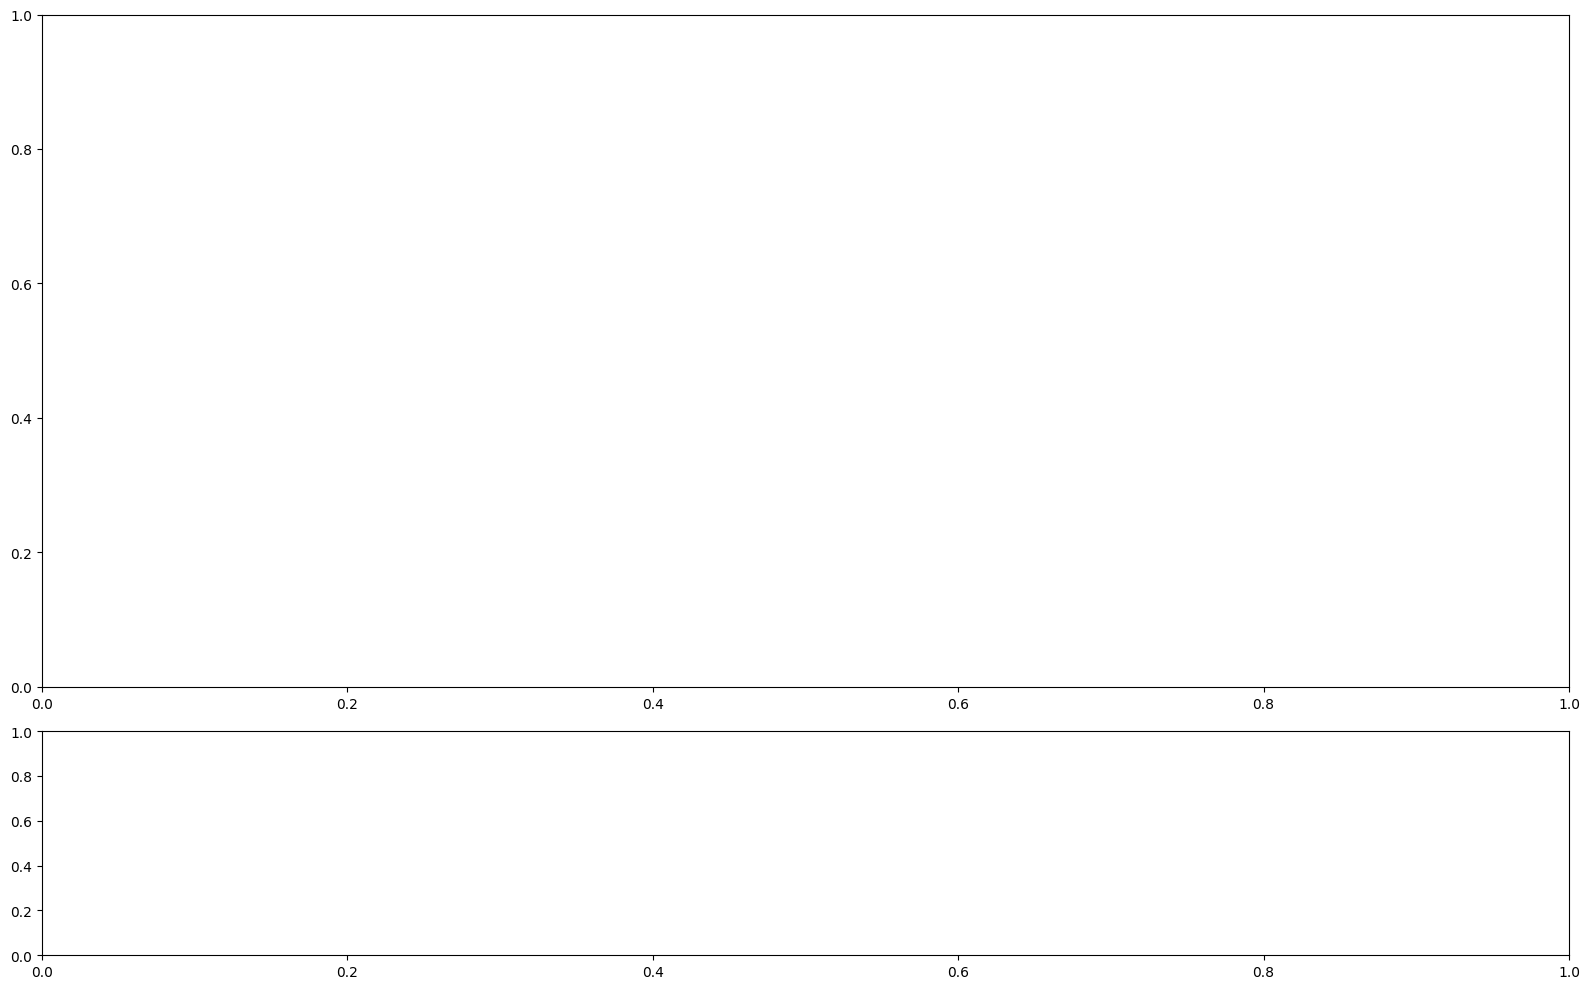


📊 Live chart is running...
💡 Close the chart window to stop
⚠️  Press Ctrl+C in terminal to force stop
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3023.25 | C: $3023.50 | V: 863.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3023.25 | C: $3023.25 | V: 883.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.50 | C: $3022.50 | V: 913.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3022.40 | V: 940.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3022.90 | V: 1026.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3023.20 | V: 1208.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3023.30 | V: 1384.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3023.20 | V: 1984.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3023.30 | V: 2184.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3023.30 | V: 2689.0
🕐 18:24:00 | O: $3023.35 | H: $3023.60 | L: $3022.40 | C: $3023.50 | V: 2691.0
🕐 18:24:00 | O: $3023.35 | H: $

In [84]:
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import time
import websocket
import json
import threading
from collections import deque
import matplotlib.animation as animation

class LiveETHUSDChart:
    def __init__(self):
        self.base_url = 'https://api.india.delta.exchange'
        self.symbol = 'FARTCOINUSD'
        self.ws_url = "wss://socket.india.delta.exchange"

        # Store live data
        self.live_candles = deque(maxlen=100)  # Keep last 100 candles
        self.current_candle = None
        self.ws = None

        # Chart setup
        self.fig, (self.ax1, self.ax2) = plt.subplots(2, 1, figsize=(16, 10),
                                                     gridspec_kw={'height_ratios': [3, 1]})

        # Animation setup
        self.ani = None

    def fetch_initial_data(self):
        """Fetch initial historical data"""
        end_time = int(time.time())
        start_time = end_time - (2 * 3600)  # 2 hours back

        url = f"{self.base_url}/v2/history/candles"
        params = {
            'symbol': self.symbol,
            'resolution': '1m',
            'start': start_time,
            'end': end_time
        }

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            if data['success'] and data['result']:
                for candle in data['result']:
                    candle['datetime'] = datetime.fromtimestamp(candle['time'])
                    self.live_candles.append(candle)
                print(f"Loaded {len(data['result'])} historical candles")
                return True
            else:
                print("No historical data received")
                return False

        except requests.exceptions.RequestException as e:
            print(f"Error fetching historical data: {e}")
            return False

    def on_websocket_message(self, ws, message):
        """Handle WebSocket messages"""
        try:
            data = json.loads(message)

            # Handle candlestick updates
            if data.get('type') == 'candlestick_1m' and data.get('symbol') == 'ETHUSD':
                candle = {
                    'time': data['candle_start_time'] // 1000000,  # Convert to seconds
                    'open': float(data['open']),
                    'high': float(data['high']),
                    'low': float(data['low']),
                    'close': float(data['close']),
                    'volume': float(data.get('volume', 0)),
                    'datetime': datetime.fromtimestamp(data['candle_start_time'] // 1000000)
                }

                # Update current candle or add new one
                if self.live_candles and self.live_candles[-1]['time'] == candle['time']:
                    # Update existing candle
                    self.live_candles[-1] = candle
                else:
                    # Add new candle
                    self.live_candles.append(candle)

                print(f"🕐 {candle['datetime'].strftime('%H:%M:%S')} | "
                      f"O: ${candle['open']:.2f} | H: ${candle['high']:.2f} | "
                      f"L: ${candle['low']:.2f} | C: ${candle['close']:.2f} | "
                      f"V: {candle['volume']:.1f}")

            # Handle ticker updates
            elif data.get('type') == 'ticker' and data.get('symbol') == 'ETHUSD':
                ticker = data
                print(f"💰 Live Price: ${ticker.get('close', 'N/A')} | "
                      f"24h Change: {ticker.get('price_change_24h', 'N/A')}%")

        except json.JSONDecodeError as e:
            print(f"Error parsing WebSocket message: {e}")
        except Exception as e:
            print(f"Error handling WebSocket message: {e}")

    def on_websocket_open(self, ws):
        """Handle WebSocket connection open"""
        print("🔗 WebSocket connected to Delta Exchange")

        # Subscribe to candlestick updates
        candlestick_subscribe = {
            "type": "subscribe",
            "payload": {
                "channels": [
                    {
                        "name": "candlestick_1m",
                        "symbols": ["ETHUSD"]
                    }
                ]
            }
        }

        # Subscribe to ticker updates
        ticker_subscribe = {
            "type": "subscribe",
            "payload": {
                "channels": [
                    {
                        "name": "v2/ticker",
                        "symbols": ["ETHUSD"]
                    }
                ]
            }
        }

        ws.send(json.dumps(candlestick_subscribe))
        ws.send(json.dumps(ticker_subscribe))
        print("📊 Subscribed to ETHUSD live data feeds")

    def on_websocket_error(self, ws, error):
        """Handle WebSocket errors"""
        print(f"❌ WebSocket error: {error}")

    def on_websocket_close(self, ws, close_status_code, close_msg):
        """Handle WebSocket connection close"""
        print(f"🔌 WebSocket connection closed: {close_status_code} - {close_msg}")

    def start_websocket(self):
        """Start WebSocket connection in separate thread"""
        self.ws = websocket.WebSocketApp(
            self.ws_url,
            on_message=self.on_websocket_message,
            on_error=self.on_websocket_error,
            on_close=self.on_websocket_close
        )
        self.ws.on_open = self.on_websocket_open

        # Start WebSocket in separate thread
        ws_thread = threading.Thread(target=self.ws.run_forever)
        ws_thread.daemon = True
        ws_thread.start()

        return ws_thread

    def update_chart(self, frame):
        """Update chart with live data"""
        if len(self.live_candles) < 2:
            return

        # Clear previous plots
        self.ax1.clear()
        self.ax2.clear()

        # Convert to DataFrame
        df = pd.DataFrame(list(self.live_candles))

        # Plot candlesticks
        self.plot_candlesticks(self.ax1, df)

        # Plot volume
        self.plot_volume(self.ax2, df)

        # Format charts
        self.format_chart(self.ax1, self.ax2, df)

    def plot_candlesticks(self, ax, df):
        """Plot OHLC candlesticks"""
        for idx, row in df.iterrows():
            x = mdates.date2num(row['datetime'])
            open_price = row['open']
            high_price = row['high']
            low_price = row['low']
            close_price = row['close']

            # Determine color (green for bullish, red for bearish)
            color = '#00ff88' if close_price >= open_price else '#ff4444'
            edge_color = '#00cc66' if close_price >= open_price else '#cc3333'

            # Draw high-low line
            ax.plot([x, x], [low_price, high_price], color=edge_color, linewidth=1.5)

            # Draw candle body
            body_height = abs(close_price - open_price)
            body_bottom = min(open_price, close_price)

            if body_height > 0:
                rect = Rectangle((x - 0.0003, body_bottom), 0.0006, body_height,
                               facecolor=color, edgecolor=edge_color, alpha=0.8, linewidth=0.5)
                ax.add_patch(rect)
            else:
                # Doji candle (open == close)
                ax.plot([x - 0.0003, x + 0.0003], [open_price, open_price],
                       color=edge_color, linewidth=2)

    def plot_volume(self, ax, df):
        """Plot volume bars"""
        colors = ['#00ff88' if close >= open else '#ff4444'
                 for close, open in zip(df['close'], df['open'])]

        ax.bar(df['datetime'], df['volume'], color=colors, alpha=0.7, width=0.0006)

    def format_chart(self, ax1, ax2, df):
        """Format chart appearance"""
        # Main chart formatting
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ax1.set_title(f'🔴 LIVE: ETHUSD 1-Minute Chart | {current_time}',
                     fontsize=16, fontweight='bold', color='#2c3e50')
        ax1.set_ylabel('Price (USD)', fontsize=12, color='#34495e')
        ax1.grid(True, alpha=0.3, color='#bdc3c7')
        ax1.set_facecolor('#ecf0f1')

        # Volume chart formatting
        ax2.set_ylabel('Volume', fontsize=12, color='#34495e')
        ax2.set_xlabel('Time', fontsize=12, color='#34495e')
        ax2.grid(True, alpha=0.3, color='#bdc3c7')
        ax2.set_facecolor('#ecf0f1')

        # Format x-axis
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        # Rotate x-axis labels
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # Add live price info
        if not df.empty:
            current_price = df.iloc[-1]['close']
            current_volume = df.iloc[-1]['volume']
            price_change = current_price - df.iloc[0]['open']
            price_change_pct = (price_change / df.iloc[0]['open']) * 100

            # Color based on price change
            change_color = '#27ae60' if price_change >= 0 else '#e74c3c'

            info_text = (f"💲 ${current_price:.2f} | "
                        f"📈 {price_change:+.2f} ({price_change_pct:+.2f}%) | "
                        f"📊 Vol: {current_volume:.1f}")

            ax1.text(0.02, 0.98, info_text, transform=ax1.transAxes,
                    fontsize=11, verticalalignment='top', color=change_color,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                             alpha=0.9, edgecolor=change_color))

            # Add live indicator
            ax1.text(0.98, 0.98, '🔴 LIVE', transform=ax1.transAxes,
                    fontsize=12, verticalalignment='top', horizontalalignment='right',
                    color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                             alpha=0.9, edgecolor='red'))

    def start_live_chart(self):
        """Start the live streaming chart"""
        print("🚀 Starting ETHUSD Live Chart...")

        # Fetch initial data
        if not self.fetch_initial_data():
            print("❌ Failed to fetch initial data")
            return

        # Start WebSocket
        ws_thread = self.start_websocket()

        # Wait a moment for WebSocket to connect
        time.sleep(2)

        # Start animation
        print("📈 Starting live chart animation...")
        self.ani = animation.FuncAnimation(
            self.fig, self.update_chart, interval=1000,  # Update every 1 second
            blit=False, cache_frame_data=False
        )

        # Show the plot
        plt.tight_layout()
        plt.show()

        return ws_thread

# Enhanced real-time chart with additional features
class AdvancedLiveChart(LiveETHUSDChart):
    def __init__(self):
        super().__init__()
        self.price_alerts = []
        self.trade_signals = []

    def add_price_alert(self, price, alert_type="above"):
        """Add price alert"""
        self.price_alerts.append({"price": price, "type": alert_type, "triggered": False})
        print(f"🔔 Price alert added: {alert_type} ${price}")

    def check_alerts(self, current_price):
        """Check and trigger price alerts"""
        for alert in self.price_alerts:
            if not alert["triggered"]:
                if alert["type"] == "above" and current_price >= alert["price"]:
                    print(f"🚨 ALERT: Price ${current_price} is above ${alert['price']}")
                    alert["triggered"] = True
                elif alert["type"] == "below" and current_price <= alert["price"]:
                    print(f"🚨 ALERT: Price ${current_price} is below ${alert['price']}")
                    alert["triggered"] = True

    def on_websocket_message(self, ws, message):
        """Enhanced message handler with alerts"""
        super().on_websocket_message(ws, message)

        # Check price alerts
        if self.live_candles:
            current_price = self.live_candles[-1]['close']
            self.check_alerts(current_price)

if __name__ == "__main__":
    print("=" * 60)
    print("🎯 ETHUSD Live Streaming Chart")
    print("=" * 60)

    # Create live chart
    live_chart = AdvancedLiveChart()

    # Add some price alerts (optional)
    # live_chart.add_price_alert(3300, "above")
    # live_chart.add_price_alert(3200, "below")

    try:
        # Start live streaming
        ws_thread = live_chart.start_live_chart()

        print("\n📊 Live chart is running...")
        print("💡 Close the chart window to stop")
        print("⚠️  Press Ctrl+C in terminal to force stop")

        # Keep the main thread alive
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\n🛑 Stopping live chart...")
        if live_chart.ws:
            live_chart.ws.close()
        print("✅ Live chart stopped")
    except Exception as e:
        print(f"❌ Error: {e}")
